In [2]:
from torch import nn
from abc import abstractmethod
from typing import List, Any, TypeVar
import torch
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, utils
from torch.optim import Adam, lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

Tensor = TypeVar("torch.tensor")


class BaseVAE(nn.Module):

    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size: int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass


class VanillaVAE(BaseVAE):

    def __init__(
        self, in_channels: int, latent_dim: int, hidden_dims: List = None, **kwargs
    ) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        out_channels=h_dim,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4 * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                hidden_dims[-1],
                hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, input: Tensor) -> List[Tensor]:
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 128, 4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs["M_N"]  # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }

    def sample(self, num_samples: int, current_device: int, **kwargs) -> Tensor:
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        return self.forward(x)[0]


# Define paths
weights_dir = "./weights/"
results_dir = "./results/"
recons_dir = results_dir + "reconstructions/"
samples = results_dir + "samples/"
log_dir = "./logs/"
latents_dir = "./latents/"

# Create directories if not exist
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(latents_dir, exist_ok=True)
os.makedirs(recons_dir, exist_ok=True)


# Hyperparameters
batch_size = 512
learning_rate = 0.001
weight_decay = 0.0
scheduler_gamma = 0.95
num_epochs = 30
latent_dim = 20
img_size = 28
kld_weight = 0.00025  # weight of KL divergence in the loss

# Number of images to embed
num_images = 5000
    
torch.manual_seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

# Load dataset
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

# Split dataset into train and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

# Initialize model, optimizer, and loss function
model = VanillaVAE(in_channels=1, latent_dim=latent_dim).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
writer = SummaryWriter(log_dir)

recon_losses = []
kl_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, _ = batch
        images = images.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss_dict = model.loss_function(*outputs, M_N=kld_weight)
        loss = loss_dict["loss"]
        loss.backward()
        optimizer.step()

        train_loss += loss.item()   
        recon_losses.append(loss_dict["Reconstruction_Loss"].item())
        kl_losses.append(loss_dict["KLD"].item())

    avg_train_loss = train_loss / len(train_loader)
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images, _ = batch
            images = images.to(device)

            outputs = model(images)
            loss_dict = model.loss_function(*outputs, M_N=kld_weight)
            val_loss += loss_dict["loss"].item()

    avg_val_loss = val_loss / len(val_loader)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
    writer.add_scalar("Loss/Reconstruction", loss_dict["Reconstruction_Loss"], epoch)
    writer.add_scalar("Loss/KLD", loss_dict["KLD"], epoch)

    if (epoch+1) % 10 == 0:
        # Save model checkpoint
        torch.save(
            model.state_dict(), os.path.join(weights_dir, f"vae_epoch_{epoch+1}.pth")
        )

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}"
    )

        
# Generate and save embeddings
latent_codes = []

model.eval()

# Loop through the first num_images images in the validation set
with torch.no_grad():
    for i in range(num_images):
        image, _ = val_dataset[i]
        image = image.unsqueeze(0).to(device)
        
        # Obtain the latent code and flatten it
        latent_code = model.encode(image)[0].cpu().numpy().flatten()
        latent_codes.append(latent_code)
        
np.save(latents_dir + "latent_codes_final.npy", latent_codes)
        
labels = []
for i in range(0, num_images):
    labels.append(val_dataset[i][1])

np.save(latents_dir + "labels.npy", labels)
np.save(latents_dir + "recon_losses_full.npy", recon_losses)
np.save(latents_dir + "kl_losses_full.npy", kl_losses)

# Close TensorBoard writer
writer.close()


2024-08-23 13:54:14.032785: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-23 13:54:14.034243: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-23 13:54:14.060149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 13:54:14.437838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Epoch 1/30: 100%|██████████| 106/106 [00:08<00:00, 11.92it/s]


Epoch [1/30], Train Loss: 0.0453, Validation Loss: 0.0201


Epoch 2/30: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s]


Epoch [2/30], Train Loss: 0.0180, Validation Loss: 0.0171


Epoch 3/30: 100%|██████████| 106/106 [00:08<00:00, 11.78it/s]


Epoch [3/30], Train Loss: 0.0164, Validation Loss: 0.0161


Epoch 4/30: 100%|██████████| 106/106 [00:09<00:00, 11.49it/s]


Epoch [4/30], Train Loss: 0.0158, Validation Loss: 0.0157


Epoch 5/30: 100%|██████████| 106/106 [00:09<00:00, 11.46it/s]


Epoch [5/30], Train Loss: 0.0153, Validation Loss: 0.0154


Epoch 6/30: 100%|██████████| 106/106 [00:08<00:00, 11.94it/s]


Epoch [6/30], Train Loss: 0.0150, Validation Loss: 0.0154


Epoch 7/30: 100%|██████████| 106/106 [00:09<00:00, 11.10it/s]


Epoch [7/30], Train Loss: 0.0148, Validation Loss: 0.0149


Epoch 8/30: 100%|██████████| 106/106 [00:09<00:00, 11.73it/s]


Epoch [8/30], Train Loss: 0.0146, Validation Loss: 0.0146


Epoch 9/30: 100%|██████████| 106/106 [00:09<00:00, 11.51it/s]


Epoch [9/30], Train Loss: 0.0145, Validation Loss: 0.0145


Epoch 10/30: 100%|██████████| 106/106 [00:08<00:00, 11.93it/s]


Epoch [10/30], Train Loss: 0.0144, Validation Loss: 0.0145


Epoch 11/30: 100%|██████████| 106/106 [00:09<00:00, 11.77it/s]


Epoch [11/30], Train Loss: 0.0143, Validation Loss: 0.0144


Epoch 12/30: 100%|██████████| 106/106 [00:09<00:00, 11.49it/s]


Epoch [12/30], Train Loss: 0.0142, Validation Loss: 0.0143


Epoch 13/30: 100%|██████████| 106/106 [00:09<00:00, 11.52it/s]


Epoch [13/30], Train Loss: 0.0141, Validation Loss: 0.0142


Epoch 14/30: 100%|██████████| 106/106 [00:08<00:00, 12.00it/s]


Epoch [14/30], Train Loss: 0.0140, Validation Loss: 0.0141


Epoch 15/30: 100%|██████████| 106/106 [00:09<00:00, 11.47it/s]


Epoch [15/30], Train Loss: 0.0139, Validation Loss: 0.0144


Epoch 16/30: 100%|██████████| 106/106 [00:08<00:00, 11.88it/s]


Epoch [16/30], Train Loss: 0.0139, Validation Loss: 0.0140


Epoch 17/30: 100%|██████████| 106/106 [00:08<00:00, 11.82it/s]


Epoch [17/30], Train Loss: 0.0138, Validation Loss: 0.0139


Epoch 18/30: 100%|██████████| 106/106 [00:09<00:00, 11.77it/s]


Epoch [18/30], Train Loss: 0.0137, Validation Loss: 0.0139


Epoch 19/30: 100%|██████████| 106/106 [00:08<00:00, 12.10it/s]


Epoch [19/30], Train Loss: 0.0136, Validation Loss: 0.0139


Epoch 20/30: 100%|██████████| 106/106 [00:09<00:00, 11.58it/s]


Epoch [20/30], Train Loss: 0.0136, Validation Loss: 0.0138


Epoch 21/30: 100%|██████████| 106/106 [00:08<00:00, 11.91it/s]


Epoch [21/30], Train Loss: 0.0135, Validation Loss: 0.0137


Epoch 22/30: 100%|██████████| 106/106 [00:08<00:00, 11.90it/s]


Epoch [22/30], Train Loss: 0.0135, Validation Loss: 0.0137


Epoch 23/30: 100%|██████████| 106/106 [00:08<00:00, 11.85it/s]


Epoch [23/30], Train Loss: 0.0135, Validation Loss: 0.0136


Epoch 24/30: 100%|██████████| 106/106 [00:09<00:00, 11.45it/s]


Epoch [24/30], Train Loss: 0.0134, Validation Loss: 0.0137


Epoch 25/30: 100%|██████████| 106/106 [00:09<00:00, 11.43it/s]


Epoch [25/30], Train Loss: 0.0134, Validation Loss: 0.0135


Epoch 26/30: 100%|██████████| 106/106 [00:09<00:00, 11.08it/s]


Epoch [26/30], Train Loss: 0.0133, Validation Loss: 0.0139


Epoch 27/30: 100%|██████████| 106/106 [00:09<00:00, 11.45it/s]


Epoch [27/30], Train Loss: 0.0133, Validation Loss: 0.0135


Epoch 28/30: 100%|██████████| 106/106 [00:09<00:00, 11.43it/s]


Epoch [28/30], Train Loss: 0.0132, Validation Loss: 0.0134


Epoch 29/30: 100%|██████████| 106/106 [00:09<00:00, 11.59it/s]


Epoch [29/30], Train Loss: 0.0132, Validation Loss: 0.0133


Epoch 30/30: 100%|██████████| 106/106 [00:09<00:00, 11.40it/s]


Epoch [30/30], Train Loss: 0.0132, Validation Loss: 0.0134


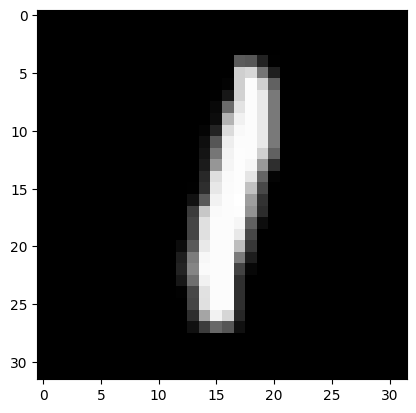

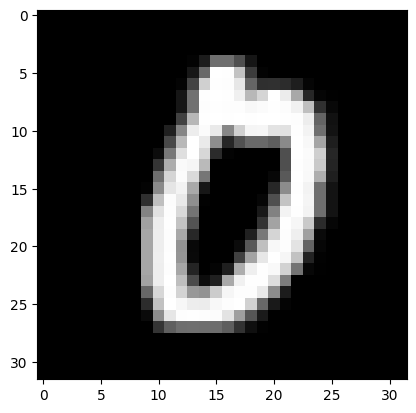

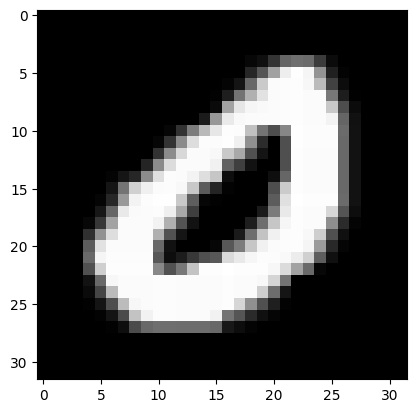

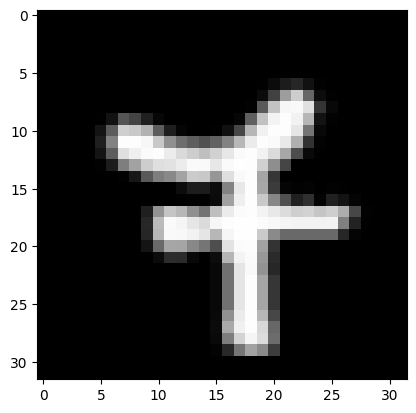

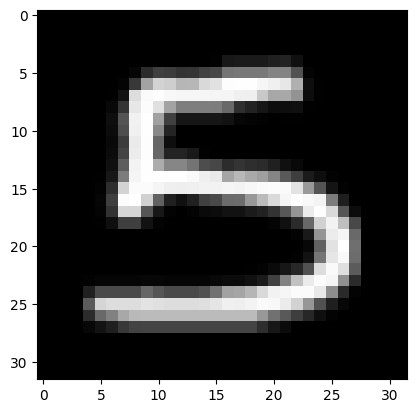

In [9]:
for i in range(0, 5, 1):
    img = val_dataset[i][0].unsqueeze(0).to(device)
    output = model(img)[0]
    output = output.squeeze().detach().cpu().numpy()
    plt.imshow(img.squeeze().detach().cpu().numpy(), cmap="gray")
    plt.show()
    
    plt.imsave(f"./reconstructions/ref_{i}.png", img.squeeze().detach().cpu().numpy(), cmap="gray")
